In [1]:
from pprint import pprint
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import tensorflow as tf
import keras
from tensorflow.python.framework import ops
#from cnn_utils import *
import os
#os.environ['CUDA_VISIBLE_DEVICES']='-1'
import deepdish.io as io
from keras.models import Sequential, Model
from keras.layers import Input, Add, Dense, Dropout, LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import multi_gpu_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc
import random

Using TensorFlow backend.


In [2]:
data_sig_A = io.load(os.path.join('../allData/MEM-A-dbsigwSpectator.h5'))
data_sig_B = io.load(os.path.join('../allData/MEM-B-dbsigwSpectator.h5'))
data_back_A = io.load(os.path.join('../allData/MEM-A-dbbkgwSpectator.h5'))
data_back_B = io.load(os.path.join('../allData/MEM-B-dbbkgwSpectator.h5'))

In [3]:
X_Big_train = data_sig_A['X']
target_BigSig_train = data_sig_A['signal_lh']
y_BigSig_train = data_sig_A['y']
target_BigBack_train = data_back_A['bkg_lh']
y_BigBack_train = data_back_A['y']

X_Big_test = data_sig_B['X']
target_BigSig_test = data_sig_B['signal_lh']
y_BigSig_test = data_sig_B['y']
target_BigBack_test = data_back_B['bkg_lh']
y_BigBack_test = data_back_B['y']

softTarget_train = target_BigSig_train/(target_BigSig_train+(0.1*target_BigBack_train))
softTarget_test = target_BigSig_test/(target_BigSig_test+(0.1*target_BigBack_test))

In [4]:
#Defining Sequential Model

#def sequential_model():
   # seqModel = Sequential()
   # seqModel.add(Dense(32, input_dim=30, kernel_initializer='glorot_normal', activation='relu'))
   # seqModel.add(Dense(12, kernel_initializer='glorot_normal', activation='relu'))
   # seqModel.add(Dense(1, kernel_initializer='glorot_normal',activation='sigmoid'))
   # seqModel.compile(loss='mean_squared_error', optimizer='adam')
   # return seqModel

def sequential_model():
    seqModel = Sequential()
    seqModel.add(Dense(1024, input_dim=30, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(512, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(256, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(32, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(16, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(8, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(1, kernel_initializer='glorot_normal',activation='sigmoid'))
    seqModel.compile(loss='binary_crossentropy', optimizer='adam')
    return seqModel

In [5]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [6]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_Big_train)
X_test = sc_X.fit_transform(X_Big_test)
model = sequential_model()
history = model.fit(X_train, y_BigSig_train, validation_data=(X_test, y_BigSig_test), epochs=100, batch_size=256, verbose=1, callbacks=[es])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3028985 samples, validate on 1009662 samples
Epoch 1/100
3028985/3028985 [==============================] - 115s 38us/step - loss: 0.0473 - val_loss: 0.0288
Epoch 2/100
3028985/3028985 [==============================] - 114s 38us/step - loss: 0.0215 - val_loss: 0.0187
Epoch 3/100
3028985/3028985 [==============================] - 114s 38us/step - loss: 0.0157 - val_loss: 0.0149
Epoch 4/100
3028985/3028985 [==============================] - 113s 37us/step - loss: 0.0128 - val_loss: 0.0142
Epoch 5/100
3028985/3028985 [==============================] - 113s 37us/step - loss: 0.0111 - val_loss: 0.0111
Epoch 6/100
3028985/3028985 [==============================] - 117s 39us/step - loss: 0.0097 - val_loss: 0.0106
Epoch 7/100
3028985/3028985 [==============================] - 120s 40us/step - loss: 0.0087 - val_loss: 0.0109
Epoch 00007: early stopping


In [7]:
sig_predict = model.predict(X_test,batch_size=256, verbose=1)

1009662/1009662 [==============================] - 11s 11us/step


/home/debo/env5/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


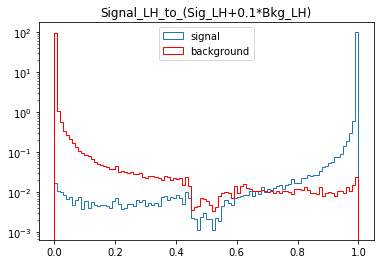

In [8]:
sigSoft= sig_predict[np.where(y_BigSig_test==1)]
bkgSoft = sig_predict[np.where(y_BigSig_test==0)]
_=plt.hist(sigSoft,bins=100, histtype='step', label='signal', normed = 1)
                           
_=plt.hist(bkgSoft,bins=100, histtype='step', color= 'red', label='background', normed = 1)

_=plt.yscale('log')

_=plt.legend(loc='upper center')

_=plt.title('Signal_LH_to_(Sig_LH+0.1*Bkg_LH)')

/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


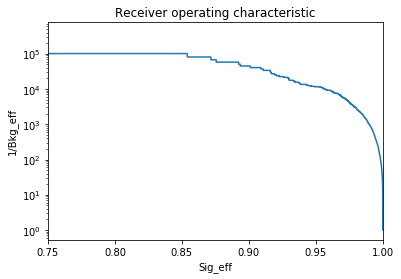

In [9]:
fpr, tpr, thresholds = roc_curve(y_BigSig_test,sig_predict)
plt.figure()
##plt.plot(fpr, tpr)
plt.plot(tpr, 1/fpr)
plt.xlim([0.75, 1])
#plt.ylim([1, 10000])
plt.ylabel('1/Bkg_eff')
plt.xlabel('Sig_eff')
plt.title('Receiver operating characteristic')
plt.yscale('log')
plt.show()

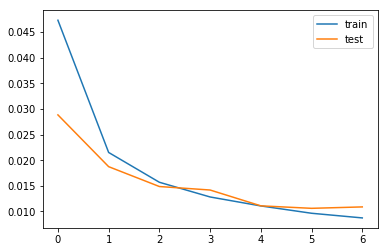

In [10]:
# evaluate the model
#_, train_acc = model.evaluate(X_train, y_BigSig_train, verbose=1)
#_, test_acc = model.evaluate(X_test, y_BigSig_test, verbose=1)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [11]:
d = io.load('../allData/MEM-A-dbsigwSpectator.h5')
#ix = [random.sample(range(4), 4) for _ in xrange(d['X'].shape[0])]
ix = np.argsort(d['X'][:, :4])[:, ::-1]

def _pairwise(iterable):
        '''s -> (s0, s1), (s2, s3), (s4, s5), ...'''
        a = iter(iterable)
        return izip(a, a)

cols = [(0, 4), (8, 12), (15, 19), (23, 27)]
for slc in cols:
      print 'Shuffling columns {}'.format(slc)
      d['X'][:, slice(*slc)] = np.array([row[sh] for row, sh in zip(d['X'][:, slice(*slc)], ix)])

X_ordered = d['X']

Shuffling columns (0, 4)
Shuffling columns (8, 12)
Shuffling columns (15, 19)
Shuffling columns (23, 27)


In [12]:
d1 = io.load('../allData/MEM-A-dbsigwSpectator.h5')
ix = [random.sample(range(4), 4) for _ in xrange(d['X'].shape[0])]
#ix = np.argsort(d['X'][:, :4])[:, ::-1]

def _pairwise(iterable):
        '''s -> (s0, s1), (s2, s3), (s4, s5), ...'''
        a = iter(iterable)
        return izip(a, a)

cols = [(0, 4), (8, 12), (15, 19), (23, 27)]
for slc in cols:
      print 'Shuffling columns {}'.format(slc)
      d1['X'][:, slice(*slc)] = np.array([row[sh] for row, sh in zip(d1['X'][:, slice(*slc)], ix)])

X_shuffled = d1['X']

Shuffling columns (0, 4)
Shuffling columns (8, 12)
Shuffling columns (15, 19)
Shuffling columns (23, 27)


In [13]:
X_Big_train[1,:]

array([ 1.55747299e+02,  1.82756454e+02,  1.37238022e+02,  2.49927765e+02,
        1.58137192e+02,  1.13366745e+02,  5.22283478e+01,  1.53766127e+01,
        2.09246492e+00, -7.29564130e-01, -6.98315203e-02, -3.07966858e-01,
        1.67793083e+00,  1.32498848e+00, -1.72354221e-01,  1.33465338e+00,
       -5.22415042e-01,  2.67757154e+00, -2.96595240e+00,  1.16517329e+00,
        6.76925600e-01, -3.00133228e-01,  1.82927525e+00,  6.40781178e+02,
        2.33637023e+02,  1.37653036e+02,  2.61915932e+02,  4.38136898e+02,
        2.28317680e+02,  5.30060171e+01])

In [14]:
X_ordered[1,:]

array([ 2.49927765e+02,  1.82756454e+02,  1.55747299e+02,  1.37238022e+02,
        1.58137192e+02,  1.13366745e+02,  5.22283478e+01,  1.53766127e+01,
       -3.07966858e-01, -7.29564130e-01,  2.09246492e+00, -6.98315203e-02,
        1.67793083e+00,  1.32498848e+00, -1.72354221e-01, -2.96595240e+00,
       -5.22415042e-01,  1.33465338e+00,  2.67757154e+00,  1.16517329e+00,
        6.76925600e-01, -3.00133228e-01,  1.82927525e+00,  2.61915932e+02,
        2.33637023e+02,  6.40781178e+02,  1.37653036e+02,  4.38136898e+02,
        2.28317680e+02,  5.30060171e+01])

In [15]:
X_shuffled[1,:]

array([ 1.37238022e+02,  1.55747299e+02,  2.49927765e+02,  1.82756454e+02,
        1.58137192e+02,  1.13366745e+02,  5.22283478e+01,  1.53766127e+01,
       -6.98315203e-02,  2.09246492e+00, -3.07966858e-01, -7.29564130e-01,
        1.67793083e+00,  1.32498848e+00, -1.72354221e-01,  2.67757154e+00,
        1.33465338e+00, -2.96595240e+00, -5.22415042e-01,  1.16517329e+00,
        6.76925600e-01, -3.00133228e-01,  1.82927525e+00,  1.37653036e+02,
        6.40781178e+02,  2.61915932e+02,  2.33637023e+02,  4.38136898e+02,
        2.28317680e+02,  5.30060171e+01])

In [16]:
sc_X = StandardScaler()
X_train1 = sc_X.fit_transform(X_ordered)
X_test1 = sc_X.fit_transform(X_Big_test)
model = sequential_model()
history = model.fit(X_train1, y_BigSig_train, validation_data=(X_test1, y_BigSig_test), epochs=100, batch_size=256, verbose=1, callbacks=[es])

Train on 3028985 samples, validate on 1009662 samples
Epoch 1/100
3028985/3028985 [==============================] - 122s 40us/step - loss: 0.1140 - val_loss: 0.2039
Epoch 2/100
3028985/3028985 [==============================] - 122s 40us/step - loss: 0.0722 - val_loss: 0.2165
Epoch 00002: early stopping


In [17]:
sig_predict_ordered = model.predict(X_test1,batch_size=256, verbose=1)

1009662/1009662 [==============================] - 11s 11us/step


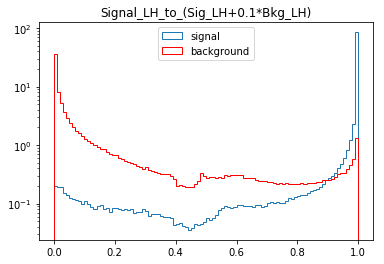

In [18]:
sigSoft= sig_predict_ordered[np.where(y_BigSig_test==1)]
bkgSoft = sig_predict_ordered[np.where(y_BigSig_test==0)]
_=plt.hist(sigSoft,bins=100, histtype='step', label='signal', normed = 1)
                           
_=plt.hist(bkgSoft,bins=100, histtype='step', color= 'red', label='background', normed = 1)

_=plt.yscale('log')

_=plt.legend(loc='upper center')

_=plt.title('Signal_LH_to_(Sig_LH+0.1*Bkg_LH)')

/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


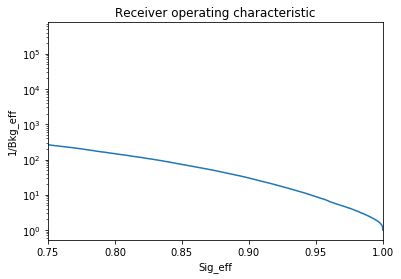

In [19]:
fpr_ordered, tpr_ordered, thresholds_ordered = roc_curve(y_BigSig_test,sig_predict_ordered)
plt.figure()
##plt.plot(fpr, tpr)
plt.plot(tpr_ordered, 1/fpr_ordered)
plt.xlim([0.75, 1])
#plt.ylim([1, 10000])
plt.ylabel('1/Bkg_eff')
plt.xlabel('Sig_eff')
plt.title('Receiver operating characteristic')
plt.yscale('log')
plt.show()

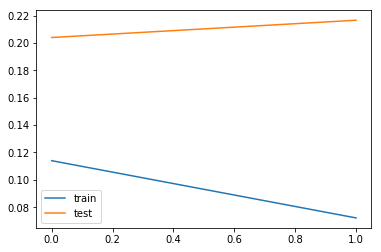

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [22]:
sc_X = StandardScaler()
X_train2 = sc_X.fit_transform(X_shuffled)
X_test2 = sc_X.fit_transform(X_Big_test)
model = sequential_model()
history = model.fit(X_train2, y_BigSig_train, validation_data=(X_test2, y_BigSig_test), epochs=100, batch_size=256, verbose=1, callbacks=[es])

Train on 3028985 samples, validate on 1009662 samples
Epoch 1/100
3028985/3028985 [==============================] - 125s 41us/step - loss: 0.1447 - val_loss: 0.3204
Epoch 2/100
3028985/3028985 [==============================] - 125s 41us/step - loss: 0.1042 - val_loss: 0.3357
Epoch 00002: early stopping


In [23]:
sig_predict_shuffled = model.predict(X_test2,batch_size=256, verbose=1)

1009662/1009662 [==============================] - 12s 11us/step


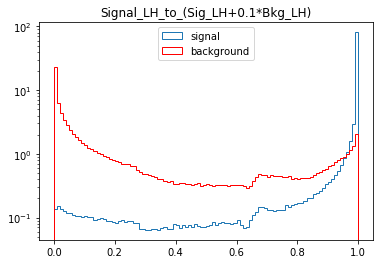

In [24]:
sigSoft= sig_predict_shuffled[np.where(y_BigSig_test==1)]
bkgSoft = sig_predict_shuffled[np.where(y_BigSig_test==0)]
_=plt.hist(sigSoft,bins=100, histtype='step', label='signal', normed = 1)
                           
_=plt.hist(bkgSoft,bins=100, histtype='step', color= 'red', label='background', normed = 1)

_=plt.yscale('log')

_=plt.legend(loc='upper center')

_=plt.title('Signal_LH_to_(Sig_LH+0.1*Bkg_LH)')

/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


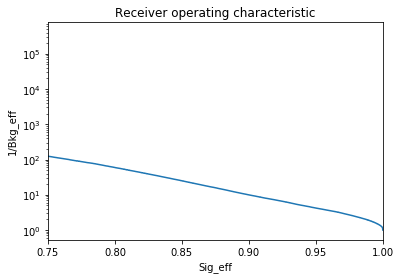

In [25]:
fpr_shuffled, tpr_shuffled, thresholds_shuffled = roc_curve(y_BigSig_test,sig_predict_shuffled)
plt.figure()
##plt.plot(fpr, tpr)
plt.plot(tpr_shuffled, 1/fpr_shuffled)
plt.xlim([0.75, 1])
#plt.ylim([1, 10000])
plt.ylabel('1/Bkg_eff')
plt.xlabel('Sig_eff')
plt.title('Receiver operating characteristic')
plt.yscale('log')

plt.show()

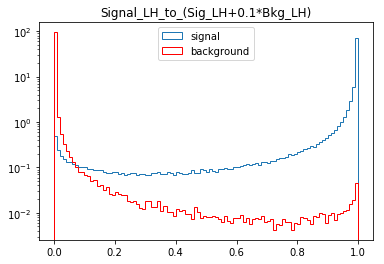

In [26]:
sigSoft= softTarget_test[np.where(y_BigSig_test==1)]
bkgSoft = softTarget_test[np.where(y_BigSig_test==0)]
_=plt.hist(sigSoft,bins=100, histtype='step', label='signal', normed = 1)
                           
_=plt.hist(bkgSoft,bins=100, histtype='step', color= 'red', label='background', normed = 1)

_=plt.yscale('log')

_=plt.legend(loc='upper center')

_=plt.title('Signal_LH_to_(Sig_LH+0.1*Bkg_LH)')

/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


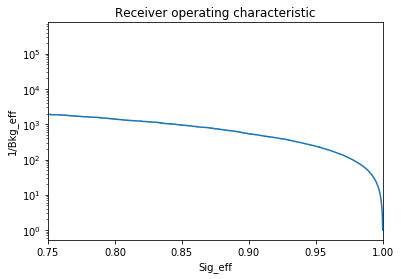

In [27]:
fpr_MEM, tpr_MEM, thresholds_MEM = roc_curve(y_BigSig_test,softTarget_test)
plt.figure()
##plt.plot(fpr, tpr)
plt.plot(tpr_MEM, 1/fpr_MEM)
plt.xlim([0.75, 1])
#plt.ylim([1, 10000])
plt.ylabel('1/Bkg_eff')
plt.xlabel('Sig_eff')
plt.title('Receiver operating characteristic')
plt.yscale('log')

plt.show()

/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  
/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.
/home/debo/env5/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


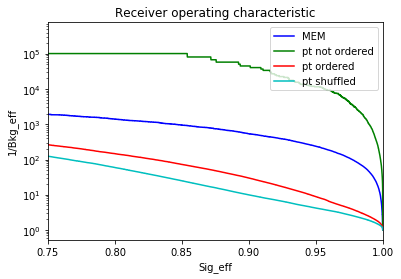

In [28]:
plt.figure()
plt.plot(tpr_MEM, 1/fpr_MEM, label='MEM',color='b')
plt.plot(tpr, 1/fpr, label='pt not ordered',color='g')
plt.plot(tpr_ordered, 1/fpr_ordered, label='pt ordered',color='r')
plt.plot(tpr_shuffled, 1/fpr_shuffled, label='pt shuffled',color='c')

plt.xlim([0.75, 1])
#plt.ylim([1, 10000])
plt.ylabel('1/Bkg_eff')
plt.xlabel('Sig_eff')
plt.title('Receiver operating characteristic')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

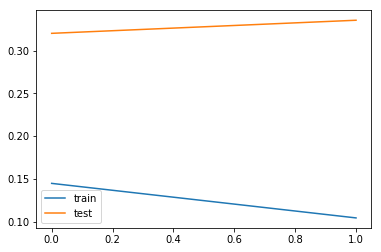

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()